# Tuning Pytorch hyperparameters with Optuna


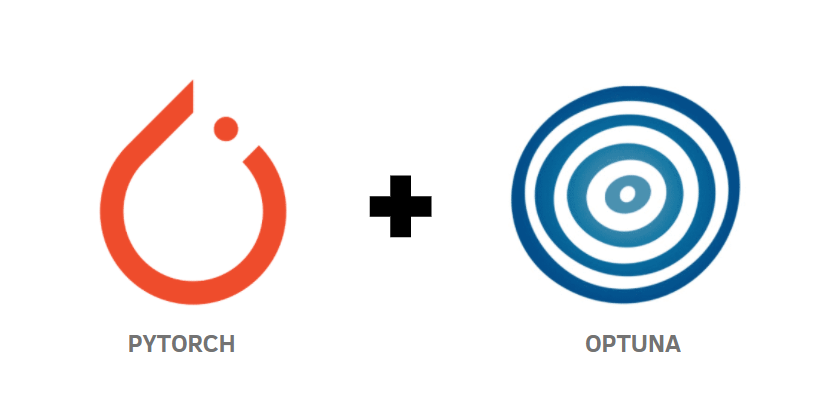

doc : https://pub.towardsai.net/tuning-pytorch-hyperparameters-with-optuna-470edcfd4dc

**Optuna**

**Optuna** is a hyperparameter optimization framework to automate hyperparameter search, which can be applied in Machine Learning and Deep Learning models. it's very fast and efficient.

Moreover, it allows building dynamically the hyperparameter search space in an intuitive way.

### MNIST Classifier with Optuna

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import random_split
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import optuna
import os 

DEVICE=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CLASSES=10
DIR=os.getcwd()
EPOCHS=10 

train_dataset=torchvision.datasets.MNIST('classifier_data', train=True, download=True)
m=len(train_dataset)

transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_dataset.transform=transform

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting classifier_data\MNIST\raw\train-images-idx3-ubyte.gz to classifier_data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting classifier_data\MNIST\raw\train-labels-idx1-ubyte.gz to classifier_data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting classifier_data\MNIST\raw\t10k-images-idx3-ubyte.gz to classifier_data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting classifier_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to classifier_data\MNIST\raw



The next step is to define the Convolutional neural network together to the hyperparameters to tune :

In [7]:
class ConvNet(nn.Module):
    def __init__(self, trial):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        dropout_rate = trial.suggest_float("dropout_rate", 0, 0.5,step=0.1)
        self.drop1=nn.Dropout2d(p=dropout_rate)   
        fc2_input_dim = trial.suggest_int("fc2_input_dim", 32, 128,32)
        self.fc1 = nn.Linear(32 * 7 * 7, fc2_input_dim)
        dropout_rate2 = trial.suggest_float("dropout_rate2", 0, 0.3,step=0.1)
        self.drop2=nn.Dropout2d(p=dropout_rate2)
        self.fc2 = nn.Linear(fc2_input_dim, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = self.fc2(x)
        return x

In Optuna, the goal is to manimize/maximize the objective function, which takes as input as set hyperparameters and returns a validation score.

In [8]:
def get_mnist(train_dataset, batch_size):
    
    train_data, val_data=random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
    # The dataloaders handle shuffline, batching, etc...
    train_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    valid_loader=torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    return train_loader, valid_loader

##### Optimization

The most importance step is to define the objective function, which uses a sampling procedure to choose the values of the hyperparameters in each trial and returns the validation accuracy obtained in the trial.

In [9]:
def objective(trial):

    # Generate the model.
    model = ConvNet(trial).to(DEVICE)

    # Generate the optimizers.

    # try RMSprop and SGD
    '''
    optimizer_name = trial.suggest_categorical("optimizer", ["RMSprop", "SGD"])
    momentum = trial.suggest_float("momentum", 0.0, 1.0)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr,momentum=momentum)
    '''
    #try Adam, AdaDelta adn Adagrad
    
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "Adadelta","Adagrad"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1,log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    batch_size=trial.suggest_int("batch_size", 64, 256,step=64)

    criterion=nn.CrossEntropyLoss()

    # Get the MNIST imagesset.
    train_loader, valid_loader = get_mnist(train_dataset,batch_size)
    
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
       
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Limiting training images for faster epochs.
            #if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
            #    break

            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(valid_loader):
                # Limiting validation images.
               # if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                #    break
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                output = model(images)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        accuracy = correct / len(valid_loader.dataset)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

After, we can finally create an study object to maximize the objective function. We run the study with **study.optimize(objective,n_trials = 20)** , where we fix the number of trials equal to 20. You can change it depending on the complexity of the problem.

In [10]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2022-07-22 13:39:59,637] A new study created in memory with name: no-name-32aef19e-d7d8-480a-ac1c-3f7712ad4e09
C:\Users\Lenovo Demo\anaconda3\envs\ml_cuda\lib\site-packages\torch\nn\functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
[I 2022-07-22 13:41:15,364] Trial 0 finished with value: 0.09708333333333333 and parameters: {'dropout_rate': 0.5, 'fc2_input_dim': 32, 'dropout_rate2': 0.3, 'optimizer': 'Adadelta', 'lr': 4.702910657023787e-05, 'batch_size': 64}. Best is trial 0 with value: 0.09708333333333333.
C:\Users\Lenovo Demo\anaconda3\envs\ml_cuda\lib\site-packages\torch\nn\functional.py:1320: UserWarning: dropout

Accuracy: 0.989
Best hyperparameters: {'dropout_rate': 0.30000000000000004, 'fc2_input_dim': 32, 'dropout_rate2': 0.3, 'optimizer': 'Adam', 'lr': 0.001879559124804965, 'batch_size': 128}


To have an easier visualization of the hyperparameters chosen in the last 5 trials, we can build a DataFrame object:

In [11]:
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
df.tail(5)

,value,params_batch_size,params_dropout_rate,params_dropout_rate2,params_fc2_input_dim,params_lr,params_optimizer
15,0.918250,192,0.4,0.3,64,0.000239,Adam
16,0.983833,64,0.4,0.1,96,0.003892,Adam
17,0.926500,128,0.3,0.2,64,0.000213,Adam
18,0.975250,192,0.1,0.3,64,0.012529,Adam
19,0.937000,64,0.4,0.2,96,0.002072,Adagrad


It’s clear that the best-performing model obtained a validation accuracy of 98.9% in the 20th trial. Moreover, you can see the hyperparameter values chosen in that trial.

#### Visualizations with Optuna

There are many interesting visualizations that help to look at different aspects of the optimization. We can see how the objective value increase as the number of trials increases.

Doc : https://optuna.readthedocs.io/en/stable/reference/visualization/matplotlib.html

In [38]:
import warnings
warnings.filterwarnings('ignore')

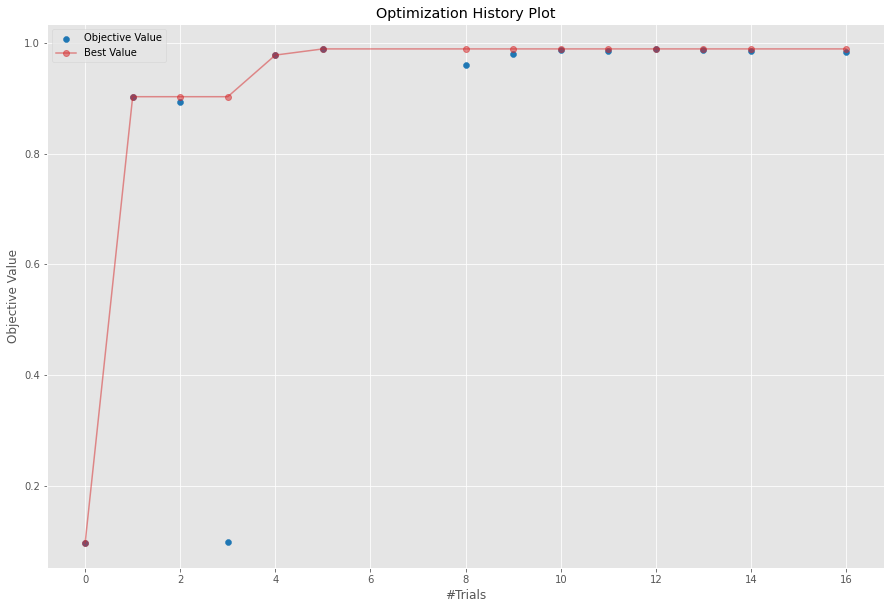

In [40]:
plt.rcParams["figure.figsize"] = (15,10)
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

On the x-axis, we have the trials, while on the y-axis there is the objective value, which corresponds to the validation accuracy. With only 20 trials, we can see that we reach good scores above 90%.

We can also show the relationship between different hyperparameters. In this case, we focus only on the batch size and the learning rate:

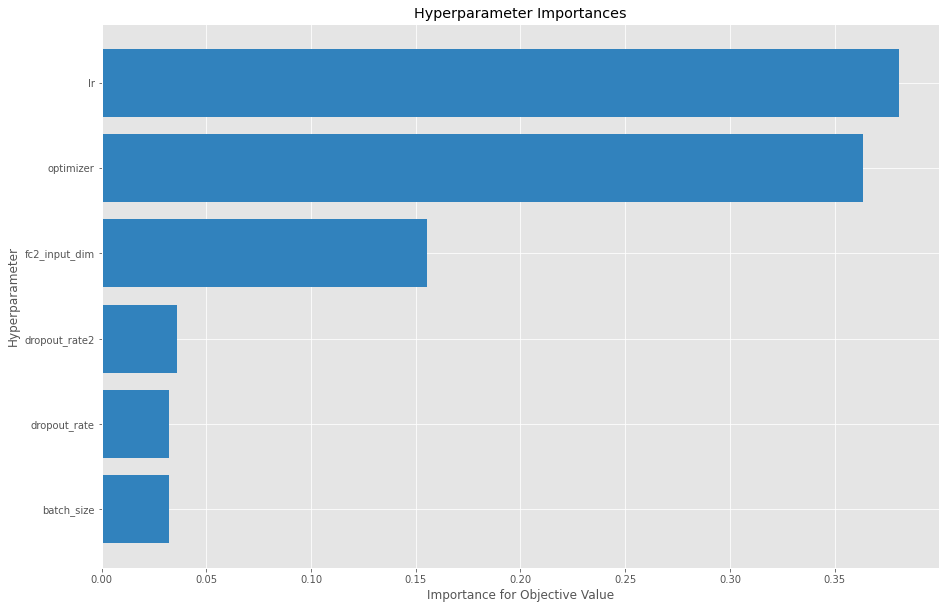

In [41]:
plt.rcParams["figure.figsize"] = (15,10)
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

[W 2022-07-22 14:29:56,040] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


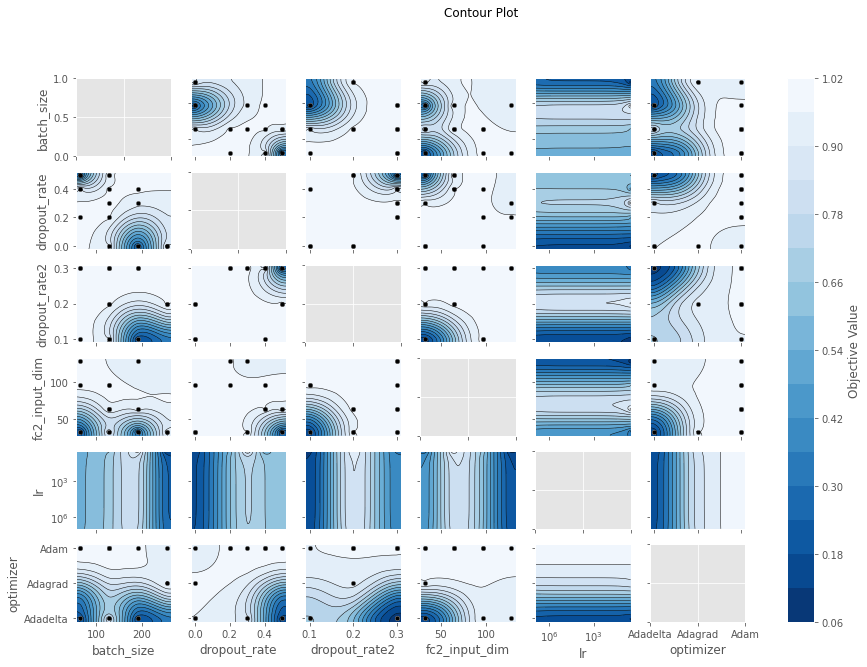

In [42]:
# Plot the parameter relationship as contour plot in a study with Matplotlib.
plt.rcParams["figure.figsize"] = (15,10)
optuna.visualization.matplotlib.plot_contour(study)
plt.show()

[W 2022-07-22 14:32:26,989] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


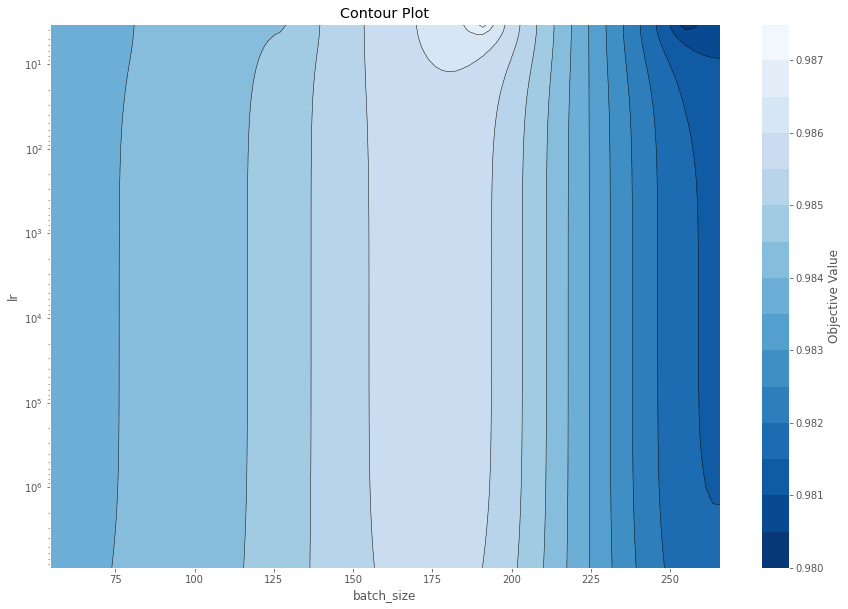

In [43]:
plt.rcParams["figure.figsize"] = (15,10)
optuna.visualization.matplotlib.plot_contour(study, params=['batch_size', 'lr'])
plt.show()

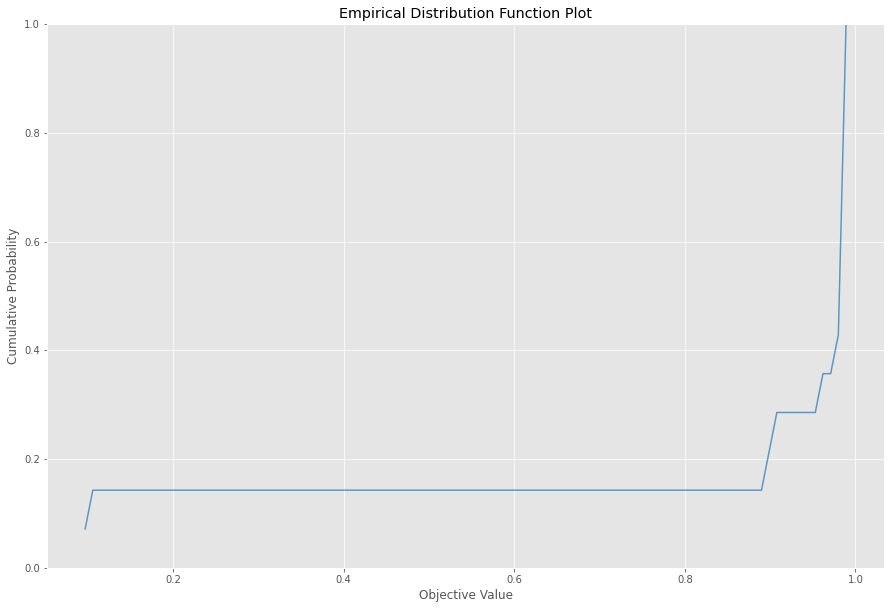

In [45]:
#Plot the objective value EDF (empirical distribution function) of a study with Matplotlib.
plt.rcParams["figure.figsize"] = (15,10)
optuna.visualization.matplotlib.plot_edf(study)
plt.show()

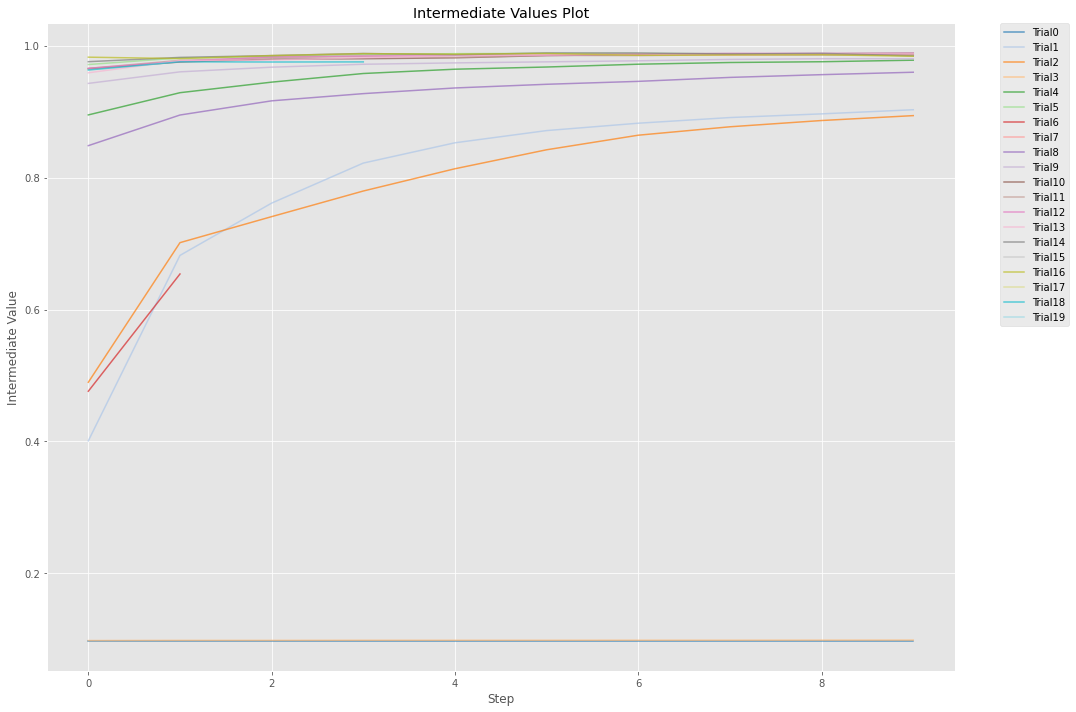

In [46]:
#Plot intermediate values of all trials in a study with Matplotlib.
plt.rcParams["figure.figsize"] = (15,10)
optuna.visualization.matplotlib.plot_intermediate_values(study)
plt.show()

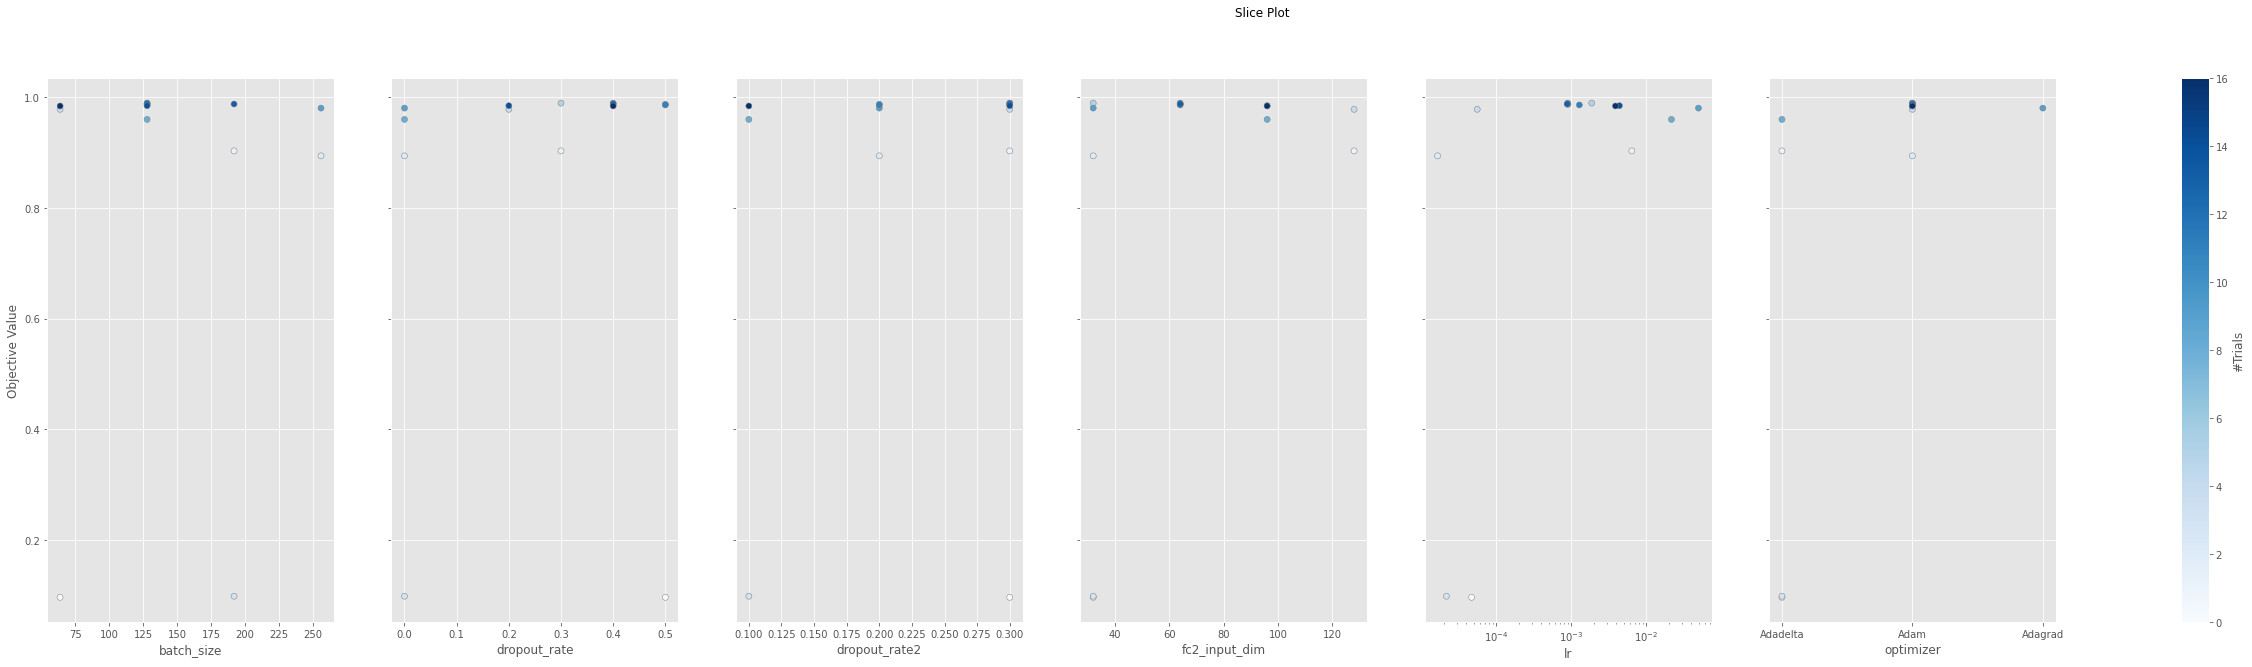

In [54]:
#Plot the parameter relationship as slice plot in a study with Matplotlib.
plt.rcParams["figure.figsize"] = (15,10)
optuna.visualization.matplotlib.plot_slice(study)
plt.show()